# Computing Mutual Information

In [2]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras.backend as K
from collections import defaultdict, OrderedDict
import seaborn as sns
sns.set_style('darkgrid')

# Saxe imports
import utils
import kde
import simplebinmi

In [3]:
def load_obj(name):
    with open('training_files/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Auxiliary functions for KDE estimator

In [4]:
# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 0.001                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

In [5]:
# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

In [6]:
DO_BINNED

False

In [7]:
DO_LOWER

False

## Training information

In [23]:
training_info = load_obj('tishby_mini_batch_train_loss_down')

In [9]:
training_info

{'data': [{'activity': [array([[-0.3486148 ,  0.33986354,  0.96102417, ...,  0.6085015 ,
             0.69892776, -0.00534401],
           [-0.2677363 ,  0.03692268,  0.9023216 , ...,  0.35243785,
             0.5325404 , -0.41322604],
           [-0.62363803,  0.20071754,  0.9767542 , ...,  0.7789734 ,
             0.84933776, -0.33588234],
           ...,
           [-0.29109266, -0.22778386,  0.54617876, ...,  0.17913763,
             0.31801933,  0.20261413],
           [-0.81422853,  0.30062032,  0.51947033, ...,  0.47043157,
             0.62239206, -0.01451623],
           [-0.4100412 , -0.25551444,  0.5306597 , ...,  0.3649713 ,
             0.40272617, -0.18477839]], dtype=float32),
    array([[-0.07836367,  0.15919825,  0.62082154, ...,  0.45582238,
             0.03377312,  0.41560686],
           [ 0.25839704, -0.2623095 ,  0.3971925 , ...,  0.31841934,
             0.23010236,  0.31251878],
           [ 0.29316518, -0.24351564,  0.75408006, ...,  0.6250434 ,
             0

## Input data

In [24]:
train, test = utils.get_IB_data('2017_12_21_16_51_3_275766')

In [25]:
train.X

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [26]:
train.Y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [27]:
train.y

array([1, 0, 1, ..., 0, 1, 0], dtype=uint8)

### Label dictionary `saved_labelixs` 

In [28]:
# Save indexes of tests data for each of the output classes
saved_labelixs = {}
FULL_MI = False
NUM_LABELS = 2

y = train.y
Y = train.Y

#y = test.y
#Y = test.Y

if FULL_MI:
    full = utils.construct_full_dataset(train,test)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

## Computing MI

In [29]:
training_info.keys()

dict_keys(['epoch', 'loss', 'loss_gen', 'data'])

In [30]:
len(training_info['data'])

1500

Epoch 0:

In [31]:
training_info['data'][0]

{'activity': [array([[ 0.5940408 ,  0.47989422,  0.26472571, ..., -0.4043251 ,
           0.92451453, -0.42398015],
         [ 0.83422935,  0.8423556 ,  0.62990344, ..., -0.870677  ,
           0.07026074, -0.95115846],
         [ 0.9380848 ,  0.15124306,  0.22908095, ...,  0.18427165,
           0.18972933,  0.9481209 ],
         ...,
         [-0.57536596,  0.6961335 , -0.8559889 , ...,  0.18414883,
           0.23235187,  0.45006242],
         [-0.20662609,  0.47461385,  0.2139657 , ...,  0.38497216,
          -0.4711893 , -0.38611257],
         [ 0.9145734 , -0.16186896, -0.22591989, ..., -0.6936079 ,
           0.7493509 , -0.31471285]], dtype=float32),
  array([[ 0.2913756 ,  0.43168068, -0.1381188 , ..., -0.490271  ,
          -0.49304056,  0.6276767 ],
         [ 0.5482577 , -0.89416206, -0.8262922 , ..., -0.19514687,
          -0.14648439,  0.5014608 ],
         [-0.90392905,  0.45605505, -0.47661778, ...,  0.18871975,
          -0.8318814 , -0.4275746 ],
         ...,
       

Epoch 1 and so on

In [18]:
training_info['data'][1]

{'activity': [array([[-0.17329358,  0.05421308,  0.9885557 , ...,  0.18571006,
          -0.17146683, -0.43358776],
         [-0.68931895,  0.19746412,  0.99549127, ...,  0.03924356,
           0.10552511,  0.07786881],
         [-0.07706261,  0.4425147 ,  0.9778489 , ...,  0.04171328,
           0.12960477, -0.34601048],
         ...,
         [-0.46861666,  0.08650246,  0.97075444, ...,  0.70971674,
           0.8080317 , -0.38732004],
         [-0.7201113 ,  0.12595335,  0.9130192 , ...,  0.47458798,
           0.7658599 , -0.10325305],
         [-0.2684733 ,  0.49273905,  0.77549124, ...,  0.21086557,
           0.45345214, -0.15446797]], dtype=float32),
  array([[-7.51748830e-02,  2.40160272e-01,  7.62301311e-02, ...,
          -3.40161920e-02,  1.42764583e-01,  1.06274076e-01],
         [ 2.85062492e-02,  2.04277143e-01,  4.03371215e-01, ...,
           5.76522201e-02, -1.30325486e-03,  2.31637612e-01],
         [-3.03676188e-01,  2.87705809e-01,  1.58517342e-02, ...,
          -

In [19]:
training_info['data'][0]['activity'][5]

array([[0.58457714, 0.41542286],
       [0.52182424, 0.47817573],
       [0.46760803, 0.53239197],
       ...,
       [0.3407091 , 0.6592909 ],
       [0.34766644, 0.65233356],
       [0.34185553, 0.6581445 ]], dtype=float32)

In [20]:
training_info['data'][10]['activity'][5].shape

(3277, 2)

#### Loop over epochs

In [45]:
#cepochdata = defaultdict(list)  ##### CHECKOUT HOW THIS WILL WORK IN OUR CONTEXT

# Data structure used to store results
#measures = OrderedDict()

#for epoch in range(len(training_info['data'])):
    
    #training_info['data'][epoch]
    
    #for layer in range(len(training_info['data'][0]['activity'])):
        
        #activity = training_info['data'][0]['activity'][layer]   
    
    

In [32]:
#### This is an auxiliary dictionary to store the results for each epoch
# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}
#measures['relu'] = {}
PLOT_LAYERS    = None 
NUM_LABELS = 2


#### Main loop: over epochs

for epoch in range(0, len(training_info['data']), 20):
#for epoch in range(0, 1):
    
    cepochdata = defaultdict(list) 
    
    #training_info['data'][epoch]
    
    print('---- EPOCH %d' % epoch)
    
    
    #####################################################################
    num_layers = len(training_info['data'][epoch]['activity'])

    if PLOT_LAYERS is None:
        PLOT_LAYERS = []
        for lndx in range(num_layers):
            #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
            PLOT_LAYERS.append(lndx)
    #####################################################################
    
    for layer in range(len(training_info['data'][epoch]['activity'])):
        
        activity = training_info['data'][epoch]['activity'][layer] 
        
        #print(epoch)
        #print(layer)
        #print(activity)
        #break
        
        #### Compute marginal entropies
        h_upper = entropy_func_upper([activity, ])[0]
        if DO_LOWER: # Why computing lower bound would not be necessary?
            h_lower = entropy_func_lower([activity, ])[0]
            
        #### Layer activity given input. This is simply the entropy of the Gaussian noise
        hM_given_X = kde.kde_condentropy(activity, noise_variance)
        
        #### Compute conditional entropies of layer activity output
        hM_given_Y_upper= 0.0
        for i in range(NUM_LABELS):
            hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
            hM_given_Y_upper += labelprobs[i] * hcond_upper
            
        if DO_LOWER:
            hM_given_Y_lower=0.0
            for i in range(NUM_LABELS):
                hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_lower += labelprobs[i] * hcond_lower
                
        cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
        cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
        cepochdata['H_M_upper'  ].append( nats2bits * h_upper )
        pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], 
                                                        cepochdata['MI_YM_upper'][-1])
        
        #print(cepochdata)
        
        ### Compute lower bounds
        if DO_LOWER: 
            cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
            cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
            cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
            pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], 
                                                                cepochdata['MI_YM_lower'][-1])
        ### Compute binned estimates
        if DO_BINNED:
            binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
            cepochdata['MI_XM_bin'].append( nats2bits * binxm )
            cepochdata['MI_YM_bin'].append( nats2bits * binym )
            pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], 
                                                              cepochdata['MI_YM_bin'][-1])
            
        print('- Layer %d %s' % (layer, pstr) )
        
    measures['tanh'][epoch] = cepochdata
        

---- EPOCH 0
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.613, MI(Y;M)=0.968
- Layer 3 upper: MI(X;M)=10.529, MI(Y;M)=0.569
- Layer 4 upper: MI(X;M)=7.819, MI(Y;M)=0.107
- Layer 5 upper: MI(X;M)=2.164, MI(Y;M)=0.002
---- EPOCH 20
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.673, MI(Y;M)=0.997
- Layer 2 upper: MI(X;M)=11.412, MI(Y;M)=0.893
- Layer 3 upper: MI(X;M)=9.391, MI(Y;M)=0.341
- Layer 4 upper: MI(X;M)=7.020, MI(Y;M)=0.105
- Layer 5 upper: MI(X;M)=2.854, MI(Y;M)=0.005
---- EPOCH 40
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.663, MI(Y;M)=0.993
- Layer 2 upper: MI(X;M)=11.432, MI(Y;M)=0.903
- Layer 3 upper: MI(X;M)=9.817, MI(Y;M)=0.449
- Layer 4 upper: MI(X;M)=6.978, MI(Y;M)=0.152
- Layer 5 upper: MI(X;M)=2.370, MI(Y;M)=0.006
---- EPOCH 60
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.659, MI(Y;M)=0.991
- Layer 2 upp

- Layer 2 upper: MI(X;M)=10.536, MI(Y;M)=0.694
- Layer 3 upper: MI(X;M)=8.303, MI(Y;M)=0.378
- Layer 4 upper: MI(X;M)=4.771, MI(Y;M)=0.159
- Layer 5 upper: MI(X;M)=1.250, MI(Y;M)=0.006
---- EPOCH 580
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.541, MI(Y;M)=0.956
- Layer 2 upper: MI(X;M)=10.477, MI(Y;M)=0.684
- Layer 3 upper: MI(X;M)=8.127, MI(Y;M)=0.353
- Layer 4 upper: MI(X;M)=4.403, MI(Y;M)=0.145
- Layer 5 upper: MI(X;M)=1.244, MI(Y;M)=0.004
---- EPOCH 600
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.553, MI(Y;M)=0.959
- Layer 2 upper: MI(X;M)=10.469, MI(Y;M)=0.680
- Layer 3 upper: MI(X;M)=8.097, MI(Y;M)=0.358
- Layer 4 upper: MI(X;M)=4.477, MI(Y;M)=0.151
- Layer 5 upper: MI(X;M)=1.324, MI(Y;M)=0.004
---- EPOCH 620
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.547, MI(Y;M)=0.958
- Layer 2 upper: MI(X;M)=10.388, MI(Y;M)=0.673
- Layer 3 upper: MI(X;M)=8.007, MI(Y;M)=0.342
- Layer 4 upper: MI(X;M)=

- Layer 4 upper: MI(X;M)=2.030, MI(Y;M)=0.037
- Layer 5 upper: MI(X;M)=0.999, MI(Y;M)=0.000
---- EPOCH 1140
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.550, MI(Y;M)=0.957
- Layer 2 upper: MI(X;M)=9.469, MI(Y;M)=0.542
- Layer 3 upper: MI(X;M)=6.242, MI(Y;M)=0.164
- Layer 4 upper: MI(X;M)=1.992, MI(Y;M)=0.031
- Layer 5 upper: MI(X;M)=0.999, MI(Y;M)=0.000
---- EPOCH 1160
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.550, MI(Y;M)=0.958
- Layer 2 upper: MI(X;M)=9.454, MI(Y;M)=0.538
- Layer 3 upper: MI(X;M)=6.212, MI(Y;M)=0.160
- Layer 4 upper: MI(X;M)=1.963, MI(Y;M)=0.032
- Layer 5 upper: MI(X;M)=0.999, MI(Y;M)=0.000
---- EPOCH 1180
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.551, MI(Y;M)=0.957
- Layer 2 upper: MI(X;M)=9.442, MI(Y;M)=0.539
- Layer 3 upper: MI(X;M)=6.179, MI(Y;M)=0.158
- Layer 4 upper: MI(X;M)=1.931, MI(Y;M)=0.030
- Layer 5 upper: MI(X;M)=0.999, MI(Y;M)=0.001
---- EPOCH 1200
- Layer 0 

In [48]:
DO_SAVE = False

## Plot

/home/rodrigo/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


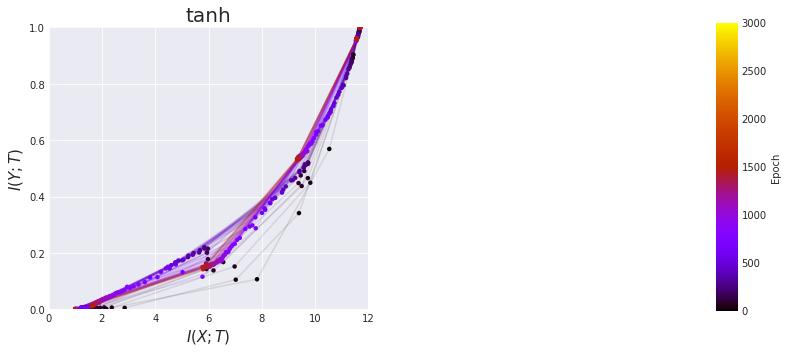

In [33]:
COLORBAR_MAX_EPOCHS= 3000
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    
    #print(vals)
    
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]
        
       
        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('$I(X;T)$', fontsize= 15)
    plt.ylabel('$I(Y;T)$', fontsize= 15)
    plt.title(activation, fontsize= 20)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    #plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')
    plt.savefig('plots/info_plane_no_mini_batch')